9 May 2017

Scott Cole

This notebook demonstrates the usage of the `compute_shape_by_cycle` in `shape.py` within the misshapen repo. This function will split up a single voltage trace into cycles and compute shape features in each cycle.

Columns in feature dataframe:

    sample : sample of 'x' at which the peak occurs
    sample_zeroxD : sample of the decaying zerocrossing
    sample_zeroxR : sample of the rising zerocrossing
    sample_lastE : sample of the last trough
    sample_nextE : sample of the next trough
    period : period of the cycle
    half_decay_time : time between peak and decay zerocross
    half_rise_time : time rise zerocross and peak
    whole_decay_time : time between peak and next trough
    whole_rise_time : time rise zerocross and previous trough
    peak_time : time between rise and decay zerocrosses
    half_decay_volt : voltage change between peak and decay zerocross
    half_rise_volt : voltage change between peak and rise zerocross
    whole_decay_volt : voltage change between peak and next trough
    whole_rise_volt : voltage change between peak and previous trough
    peak_volt : voltage at the peak
    half_decay_sharp : steepness between peak and decay zerocross
    half_rise_sharp : steepness between peak and rise zerocross
    whole_decay_sharp : steepness between peak and next trough
    whole_rise_sharp : steepness between peak and previous trough
    peak_sharp : sharpness of peak
    rdsym_time : asymmetry between the whole rise and decay times
    rdsym_volt : asymmetry between the whole rise and decay voltages
    rdsym_sharp : asymmetry between the whole rise and decay steepnesses
    oscillating_amp : True if the cycle is part of an ongoing oscillation (defined by amplitude consistency)
    oscillating_amp_time : True if cycle is part of an ongoing oscillation (defined by amplitude and time consistency)

### Load libraries

In [3]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('white')

import sys
#sys.path.append("C:/Users/user/Desktop/ipynb/misshapen/")
sys.path.append("C:/Users/Yimeng/Documents/GitHub/")
from misshapen import shape, nonshape

import util
import imp
imp.reload(util)

<module 'util' from 'C:\\Users\\Yimeng\\Documents\\GitHub\\LabWork\\util.py'>

# 1. Load data

In [4]:
data_paths, all_regions = util.load_paths()
print(all_regions)
subj = 'jc'
electrode = 0
x = np.load(data_paths[subj]['1'][electrode]) # voltage series
Fs = 1000 # sampling rate
f_range = (10,30) # frequency range of oscillation of interest
t = np.arange(0,len(x)/Fs,1/Fs) # time array
df = pd.read_csv('behavior_all.csv',index_col=0)
dfbp = df[df['subject']=='jc']

{'bp': ['0', '1', '2', '3', '4', '6', '7'], 'cc': ['0', '1', '2', '3', '4', '6', '7', '9'], 'ht': ['0', '1', '3', '4', '7', '8', '9'], 'jc': ['0', '1', '2', '3', '4', '6', '7', '8'], 'jp': ['0', '1', '4', '5', '6', '7', '8', '9'], 'wc': ['0', '1', '2', '3', '4', '6', '7', '8', '9'], 'wm': ['0', '1', '2', '5', '6', '7'], 'zt': ['0', '1', '3', '4', '6', '7', '8']}


# 2. Compute oscillations features
Note that some errors occur during peak and trough detection on a minority of cycles. These are usually time periods in which the oscillations is nonexistant anyway.

In [8]:
findpt_kwargs = {'filter_fn':nonshape.bandpass_default,
                'filter_kwargs': {'w':3}}
define_true_oscillating_periods_kwargs = {'ampdiff_th':.5, 'timediff_th':.6}
df_P, df_T = shape.compute_shape_by_cycle(x, f_range, Fs,
                                          findpt_kwargs=findpt_kwargs,
                                          define_true_oscillating_periods_kwargs=define_true_oscillating_periods_kwargs)
type(df_T)

C:\Users\Yimeng\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
C:\Users\Yimeng\Anaconda3\lib\site-packages\numpy\core\_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


C:/Users/Yimeng/Documents/GitHub\misshapen\shape.py:738: RuntimeWarning: invalid value encountered in true_divide
  trough_stats['half_decay_time']
C:/Users/Yimeng/Documents/GitHub\misshapen\shape.py:740: RuntimeWarning: invalid value encountered in true_divide
  trough_stats['half_rise_time']
C:/Users/Yimeng/Documents/GitHub\misshapen\shape.py:782: RuntimeWarning: invalid value encountered in true_divide
  peak_stats['half_decay_time']
C:/Users/Yimeng/Documents/GitHub\misshapen\shape.py:784: RuntimeWarning: invalid value encountered in true_divide
  peak_stats['half_rise_time']


pandas.core.frame.DataFrame

# 3. Compare shape features to raw data
Display features for each cycle. Assure that feature values make sense when compared to the raw data

    a. Trough sharpness
    b. Period
    c. Rise-decay symmetry
    d. Trough time
    e. Is oscillating?

In [7]:
# Limit dataframe to only features of interest for part of the signal
tlim = (14,16)
df_1sec = df_T.loc[(df_T['sample'] > tlim[0]*Fs) & (df_T['sample'] < tlim[1]*Fs)]
df_1sec = df_1sec[['amp_mean', 'period', 'ptsym_time', 'rdsym_time',
                   'sample', 'sample_lastE', 'sample_nextE', 'sample_zeroxD', 'sample_zeroxR',
                   'trough_sharp', 'trough_time', 'trough_volt', 'whole_decay_time',
                   'whole_rise_time', 'whole_rise_volt', 'oscillating_amp', 'oscillating_amp_time']]
df_T_part = df_T[['amp_mean', 'period', 'ptsym_time', 'rdsym_time',
                   'sample', 'sample_lastE', 'sample_nextE', 'sample_zeroxD', 'sample_zeroxR',
                   'trough_sharp', 'trough_time', 'trough_volt', 'whole_decay_time',
                   'whole_rise_time', 'whole_rise_volt', 'oscillating_amp', 'oscillating_amp_time']]


pandas.core.frame.DataFrame

In [148]:
def plot_feature_at_trough(df, x, t, tlim, feature, plot_title,
                           mark_troughs=False, mark_peaks=False,
                           mark_zeroxR=False, mark_zeroxD=False):
    samps = np.argwhere(np.logical_and(t>=tlim[0], t<tlim[1]))
    plt.figure(figsize=(16,3))
    plt.plot(t[samps], x[samps],'k')
    if mark_troughs:
        plt.plot(t[df['sample'].values], x[df['sample'].values], 'bo')
    if mark_peaks:
        plt.plot(t[df['sample_nextE'].values], x[df['sample_nextE'].values], 'ro')
    if mark_zeroxR:
        plt.plot(t[df['sample_zeroxR'].values], x[df['sample_zeroxR'].values], 'go')
    if mark_zeroxD:
        plt.plot(t[df['sample_zeroxD'].values], x[df['sample_zeroxD'].values], 'mo')
    plt.xlim(tlim)

    ax = plt.gca()
    for i in range(len(df_1sec)):
        trough_sample = df['sample'].values[i]
        label = df[feature].values[i]
        ax.text(t[trough_sample]-.01, x[trough_sample]-700, str(int(label)), fontsize=15)
    #plt.ylim((-1000,400))
    plt.xlabel('Time (s)', size=20)
    plt.ylabel('Voltage (uV)', size=20)
    plt.title(plot_title, size=20)

### 3a. Trough sharpness

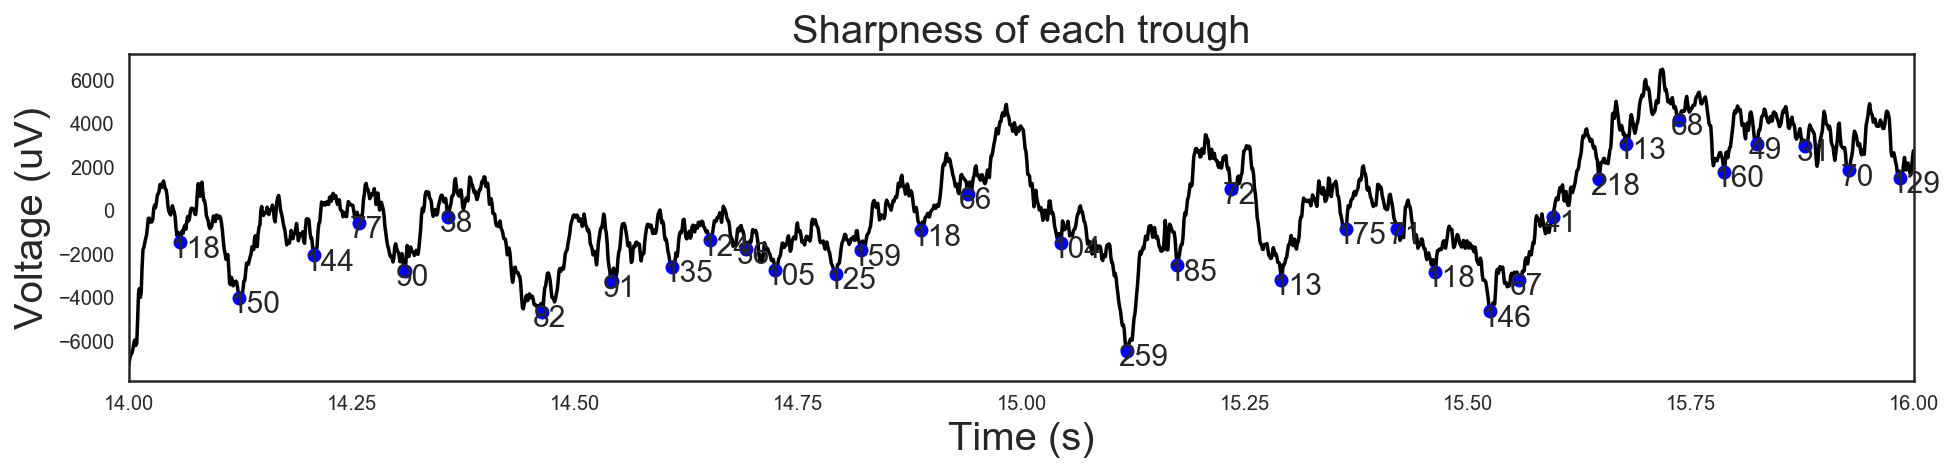

In [149]:
plot_feature_at_trough(df_1sec, x, t, tlim,
                       'trough_sharp', 'Sharpness of each trough',
                       mark_troughs=True)

### 3b. Period

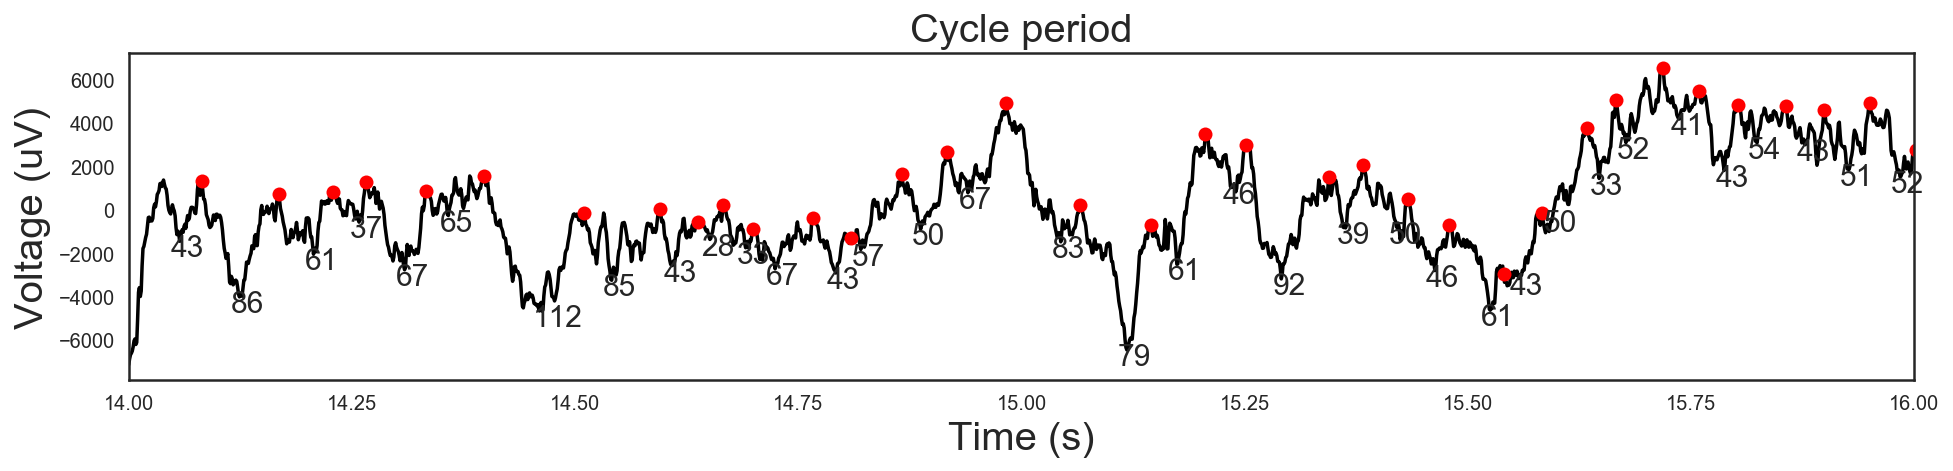

In [150]:
plot_feature_at_trough(df_1sec, x, t, tlim,
                       'period', 'Cycle period',
                       mark_peaks=True)

### 3c. Rise-decay symmetry

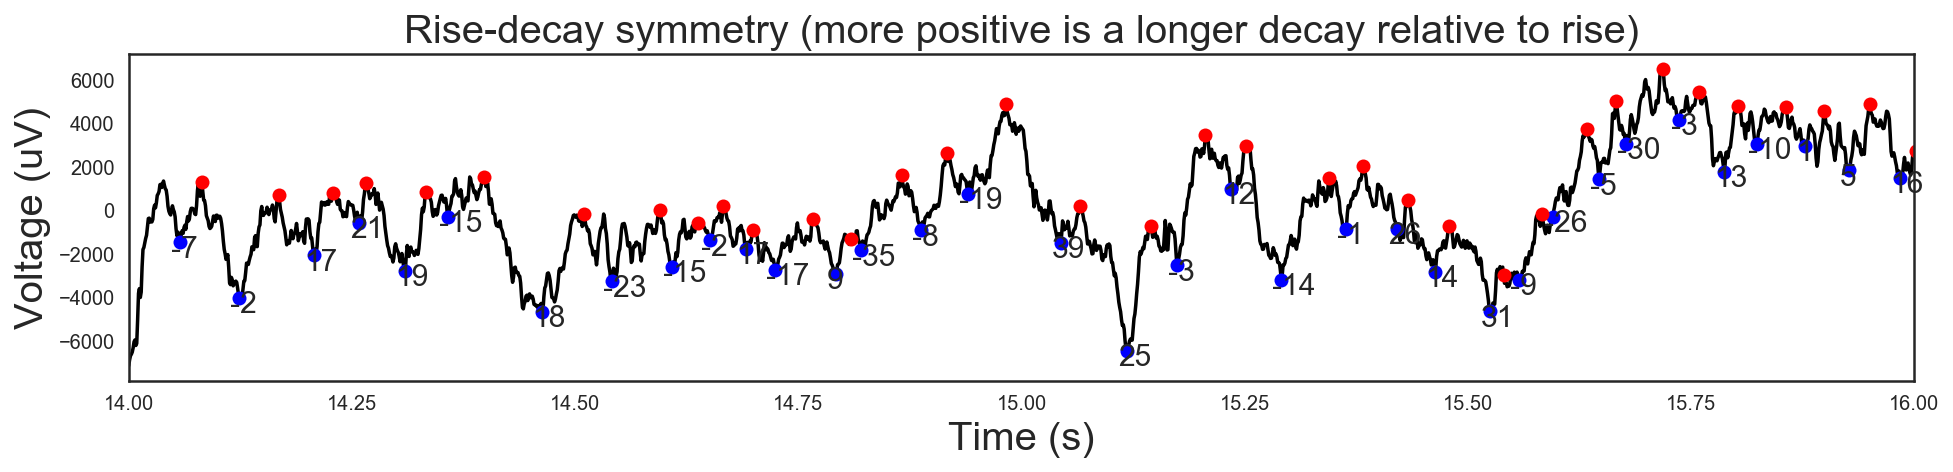

In [151]:
plot_feature_at_trough(df_1sec, x, t, tlim,
                       'rdsym_time', 'Rise-decay symmetry (more positive is a longer decay relative to rise)',
                       mark_peaks=True, mark_troughs=True)

### 3d. Trough duration

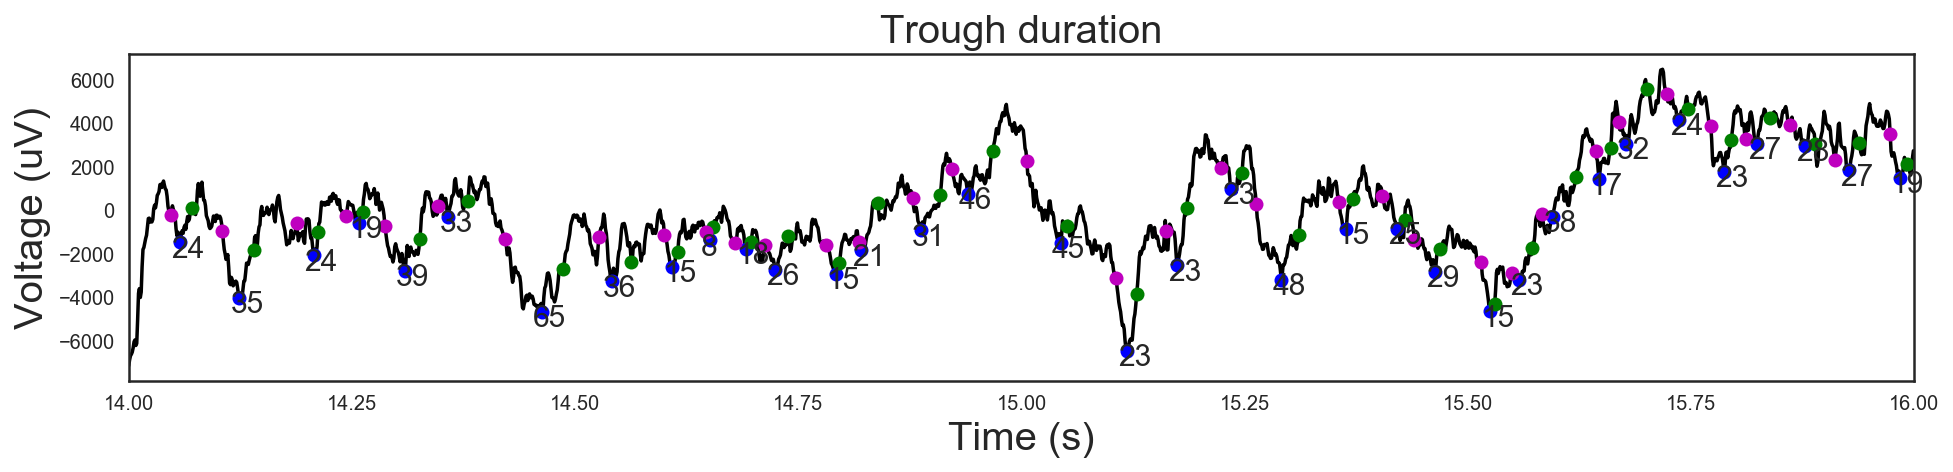

In [152]:
plot_feature_at_trough(df_1sec, x, t, tlim,
                       'trough_time', 'Trough duration',
                       mark_troughs=True, mark_zeroxR=True, mark_zeroxD=True)

### 3e. Is oscillating?

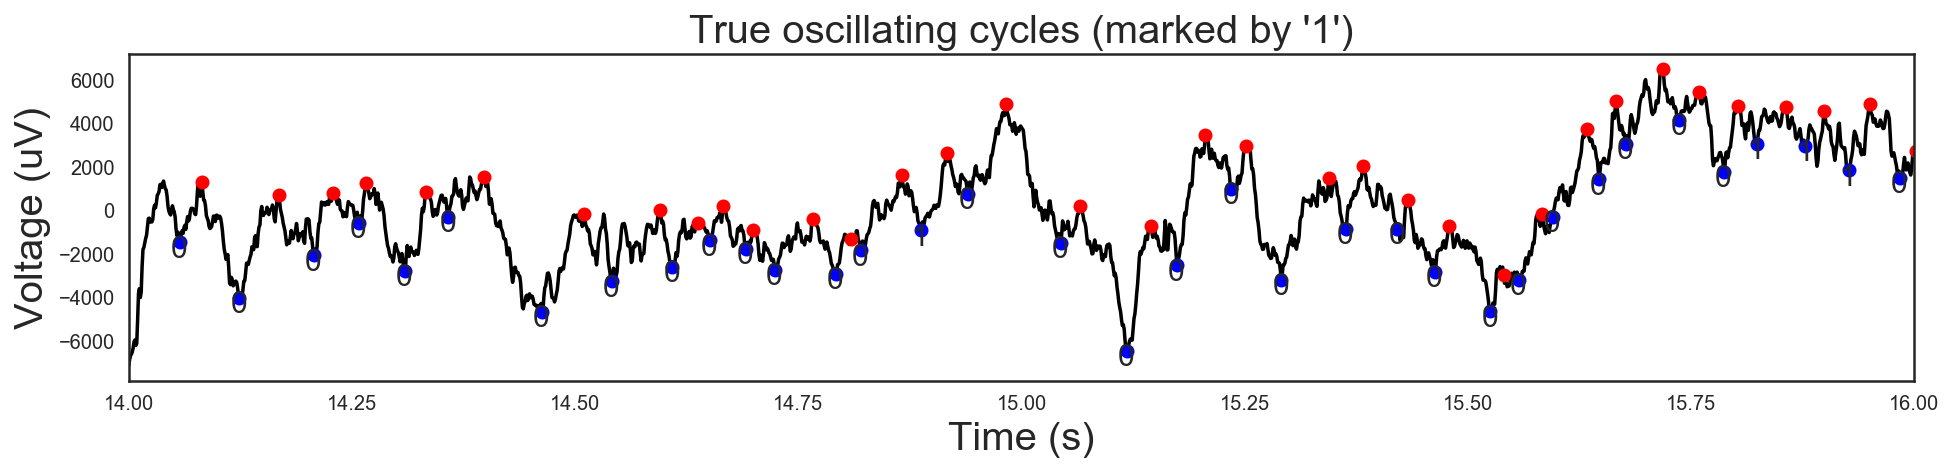

In [153]:
plot_feature_at_trough(df_1sec, x, t, tlim,
                       'oscillating_amp_time', 'True oscillating cycles (marked by \'1\')',
                       mark_troughs=True, mark_peaks=True)